In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf
from sklearn.metrics.pairwise import linear_kernel # 코사인 유사도
from konlpy.tag import Okt # 토큰화
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from soynlp.normalizer import emoticon_normalize, repeat_normalize
import soynlp.tokenizer
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import optimizers
import keras.utils
import sklearn.metrics as metrics
from konlpy.tag import Komoran
from pykospacing import spacing # 띄어쓰기
from hanspell import spell_checker # 맞춤법
import pickle
from tqdm import trange, notebook # show progress-bar

In [2]:
data = pd.read_csv("train.hate.csv")
data

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate
...,...,...
11682,여자 좋아하게 생겪다,hate
11683,바다가 좋으면 해군을 가야지,none
11684,구라도 되는걸 치시길,none
11685,나 해경전경출신있데..잘선택했다 충분히 가치있는 군생활 될꺼다,none


In [3]:
okt=Okt()

In [ ]:
# df = pd.read_csv("stop_words.csv",header=None,encoding='cp949')
# stopwords = df[1].tolist()

In [29]:
# df = pd.read_csv("data/korean_stopwords.txt",header=None)
# stopwords = df[0].tolist()

In [18]:
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [4]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = set(stopwords)

In [284]:
# sen = "대체왜않돼는지설명을해바"
# sen = spacing(sen)
# spelled_sent = spell_checker.check(sen)
# checked_sent = spelled_sent.checked
# checked_sent

'대체 왜 안되는지 설명을 해봐'

In [5]:
# okt 띄어쓰기, 맞춤법 X
token=[]
for i in notebook.tqdm(data['comments']):
    hangul=re.compile('[^ ㄱ-ㅎㅏ-ㅣ가-힣]+')
    i = hangul.sub('', i) 
    i=repeat_normalize(i,num_repeats=2) # 반복되는 문자 정제
    temp = okt.morphs(i,stem=True,norm=True)
    temp= [word for word in temp if not word in stopwords]
    token.append(temp)


In [748]:
# # okt 띄어쓰기, 맞춤법 포함
# token=[]
# for i in notebook.tqdm(data['comments']):
#     hangul=re.compile('[^ ㄱ-ㅎㅏ-ㅣ가-힣]+')
#     i = hangul.sub('', i) 
#     i=repeat_normalize(i,num_repeats=3) # 반복되는 문자 정제
#     i = spacing(i) # 띄어쓰기
#     i = spell_checker.check(i)
#     i = i.checked # 맞춤법
#     temp = okt.morphs(i,stem=True,norm=True)
#     temp= [word for word in temp if not word in stopwords]
#     token.append(temp)


In [873]:
# with open('token.p', 'rb') as file: # mecab tokenizer
#     token = pickle.load(file)
#     print(token)


[['현재', '호텔', '주인', '심정', '아', '난', '마른', '하늘', '날벼락', '맞', '호텔', '망하', '생겼', '는데', '누군', '계속', '추모', '받'], ['한국', '적', '미인', '대표', '적', '분', '너무나', '곱', '아름다운', '모습', '그', '모습', '뒤', '슬픔', '미처', '알', '못했', '네요', 'ㅠ'], ['못', '된', '넘', '남', '고통', '즐겼', '던', '넘', '이젠', '마땅', '처벌', '받', '아야지', '그래야', '공정', '사회', '지심', '대', '로', '거두', '거라'], ['화', '어설펐', '는데', '화', '지나', '서', '부터', '갈수록', '너무', '재밌', '던데'], ['사람', '얼굴', '손톱', '긁', '것', '인격', '살해', '동영상', '몰카', '냐', '메', '걸리', '안들', '생각', '없', '노'], ['진짜', '이승기', '랑', '비교', '된다'], ['년', '안', '남녀', '간', '성', '전쟁', '번', '크', '치룬', '후', '일부다처제', '여성', '정치', '참여', '금지', '여성', '투표', '권', '삭제', '세계', '공통', '문화', '로', '자리', '잡', '암탉', '너무', '울', '어', '댐'], ['년', '뒤', '윤서인', '분명히', '재', '평가', '될', '것', '말', '하나하나', '틀린', '없'], ['년', '재미', '느끼', '프로', '였', '는데', '왜', '니', '때문', '폐지', '해야', '냐'], ['년차', '방탄', '팬', '인데', '우리', '방탄', '처럼', '성공', '못', '겠', '지만', '일단', '방탄', '부하', '싶', '다는', '거', '니', '름기억은해둠ㅇㅇ'], ['살', '차이', '넘', '텐데', '부부', '라고', '무슨',

In [749]:
# # Komoran
# komoran = Komoran()
# token=[]
# for i in data['comments']:
#     hangul=re.compile('[^ ㄱ-ㅣ가-힣]+')
#     i = hangul.sub('', i) 
#     i=repeat_normalize(i,num_repeats=3) # 반복되는 문자 정제
#     temp = komoran.morphs(i)
#     temp= [word for word in temp if not word in stopwords]
#     token.append(temp)

In [750]:
# # Mecab
# mecab = Mecab(dicpath='C;\mecab\mecab-ko-dic')
# token=[]
# for i in data['comments']:
#     hangul=re.compile('[^ ㄱ-ㅣ가-힣]+')
#     i = hangul.sub('', i) 
#     i=repeat_normalize(i,num_repeats=3) # 반복되는 문자 정제
#     temp = mecab.morphs(i)
#     temp= [word for word in temp if not word in stopwords]
#     token.append(temp)

In [6]:
token = pd.Series(token)

In [7]:
data['token'] = token

In [8]:
data['label'].value_counts()

none         5005
offensive    4011
hate         2671
Name: label, dtype: int64

In [9]:
df = data[['label','token']]

In [10]:
df.to_csv("token.csv")

In [97]:
train, test = train_test_split(df, test_size=0.3)

In [98]:
print(train.shape)
print(test.shape)

(8180, 2)
(3507, 2)


In [99]:
xTrain = train['token'].tolist()
xTest = test['token'].tolist()

In [100]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xTrain)

In [101]:
print(tokenizer.word_index)

{'보다': 1, '아니다': 2, '있다': 3, '없다': 4, 'ㅋㅋ': 5, '되다': 6, '안': 7, '좋다': 8, '같다': 9, '사람': 10, '이다': 11, '로': 12, '못': 13, '나오다': 14, '여자': 15, '왜': 16, '진짜': 17, '나': 18, '에서': 19, '너무': 20, '그렇다': 21, '하고': 22, '들다': 23, '가다': 24, '아': 25, '그': 26, '더': 27, '않다': 28, '많다': 29, '뭐': 30, 'ㅋㅋㅋ': 31, '인데': 32, '것': 33, '때': 34, '드라마': 35, '알다': 36, '이쁘다': 37, '남자': 38, '니': 39, '거': 40, '말': 41, '받다': 42, '애': 43, '결혼': 44, '씨': 45, '저': 46, '그냥': 47, '적': 48, '자다': 49, '생각': 50, '연기': 51, '라': 52, '모르다': 53, '먹다': 54, '까지': 55, 'ㅋ': 56, '오다': 57, '기사': 58, '랑': 59, '년': 60, '돈': 61, '요': 62, '냐': 63, '지다': 64, '연예인': 65, '야': 66, '내': 67, '이제': 68, 'ㅠㅠ': 69, '방송': 70, '댓글': 71, '한테': 72, '일': 73, '이나': 74, '얼굴': 75, '나다': 76, '살다': 77, '넘다': 78, '보고': 79, '개': 80, '해주다': 81, '차다': 82, '정말': 83, '서': 84, '또': 85, '예쁘다': 86, '팬': 87, '안되다': 88, '맞다': 89, '치다': 90, '부터': 91, '난': 92, '욕': 93, '돼다': 94, '님': 95, '하나': 96, '정도': 97, '응원': 98, '이랑': 99, '무슨': 100, '이렇다': 101, '근데': 102, '중': 103

In [102]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 12387
등장 빈도가 1번 이하인 희귀 단어의 수: 5931
단어 집합에서 희귀 단어의 비율: 47.88084281908452
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.110779121762245


In [103]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6458


In [104]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(xTrain)
xTrain = tokenizer.texts_to_sequences(xTrain)
xTest = tokenizer.texts_to_sequences(xTest)

In [105]:
xTrain = np.array(xTrain)

In [106]:
xTest = np.array(xTest)

In [107]:
xTrain.shape

(8180,)

In [108]:
xTest.shape

(3507,)

In [109]:
yTrain = np.array(train['label'])
yTest = np.array(test['label'])

In [110]:
yTrain.shape

(8180,)

In [111]:
yTest.shape

(3507,)

리뷰의 최대 길이 : 107
리뷰의 평균 길이 : 11.865281173594132


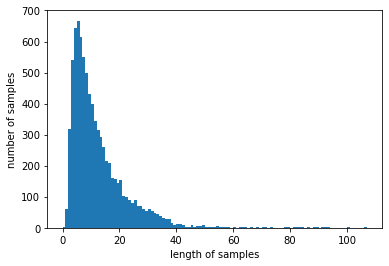

In [112]:
print('리뷰의 최대 길이 :',max(len(l) for l in xTrain))
print('리뷰의 평균 길이 :',sum(map(len, xTrain))/len(xTrain))
plt.hist([len(s) for s in xTrain], bins=max(len(l) for l in xTrain))
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [113]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [114]:
max_len = 40
below_threshold_len(max_len, xTrain)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.61858190709046


In [115]:
xTrain = pad_sequences(xTrain, maxlen = max_len,padding='post')
xTest = pad_sequences(xTest, maxlen = max_len,padding='post')

In [116]:
print(len(xTrain))
print(len(yTrain))

8180
8180


In [117]:
xTrain

array([[ 590,    3,    6, ...,    0,    0,    0],
       [ 255,    5,  548, ...,    0,    0,    0],
       [ 743, 2484,  354, ...,    0,    0,    0],
       ...,
       [ 724,  284,    3, ...,    0,    0,    0],
       [1334,    1,  102, ...,    0,    0,    0],
       [   1,  244, 1438, ...,    0,    0,    0]])

In [118]:
def vs(seq):
    res = np.zeros((len(seq),len(yTrain))) 
    for i,sequence in enumerate(seq):
        res[i, sequence] = 1
                 
    return res

xTrain = vs(xTrain)
xTest = vs(xTest)

In [119]:
# for i in range(len(yTrain)):
#     if yTrain[i] == 'offensive':
#         yTrain[i] = float(1)
      
#     elif yTrain[i] == 'hate':
#         yTrain[i] = float(2)
  
#     elif yTrain[i] == 'none':
#         yTrain[i] = float(0)
      
#     else:
#         pass
  

In [120]:
# binary classification
for i in range(len(yTrain)):
    if yTrain[i] == 'none':
        yTrain[i] = float(0)
      
    else:
        yTrain[i] = float(1)

In [121]:
# for i in range(len(yTest)):
#     if yTest[i] == 'hate':
#         yTest[i] = float(2)
      
#     elif yTest[i] == 'offensive':
#         yTest[i] = float(1)
      
#     elif yTest[i] == 'none':
#         yTest[i] = float(0)
      
#     else:
#         pass


In [122]:
# binary classification
for i in range(len(yTest)):
    if yTest[i] == 'none':
        yTest[i] = float(0)
      
    else:
        yTest[i] = float(1)


In [123]:
yTrain = yTrain.astype(float)
yTest = yTest.astype(float)
print(yTrain)
print(yTest)

[0. 1. 0. ... 0. 0. 1.]
[1. 0. 1. ... 1. 1. 0.]


In [124]:
# yTrain = keras.utils.to_categorical(yTrain, 3)
# yTest = keras.utils.to_categorical(yTest, 3)

In [125]:
# # 변수 저장
# with open('new_variables.p', 'wb') as file:    
#     pickle.dump(xTrain, file)
#     pickle.dump(xTest, file)
#     pickle.dump(yTrain, file)
#     pickle.dump(yTest, file)

In [126]:
# # 변수 불러오기
# with open('check_X,repeat_2.p', 'rb') as file:    
#     xTrain = pickle.load(file)
#     xTest = pickle.load(file)
#     yTrain = pickle.load(file)
#     yTest = pickle.load(file)
#     print(xTrain)
#     print(xTest)
#     print(yTrain)
#     print(yTest)

In [127]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [128]:
# LSTM
# model = Sequential()
# model.add(Embedding(len(xTrain),max_len))
# model.add(LSTM(16))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation = 'sigmoid'))
# model.summary()

In [129]:
# # GRU
# model = Sequential()
# model.add(Embedding(len(xTrain),max_len))
# model.add(GRU(16))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation = 'sigmoid'))
# model.summary()

In [130]:
# model = Sequential()
# model.add(Dense(512,input_dim = len(xTrain),activation='relu'))
# model.add(Dense(256,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(3, activation = 'softmax'))
# model.summary()

In [148]:
model = Sequential()
model.add(Dense(512,input_dim = len(xTrain),activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               4188672   
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,336,513
Trainable params: 4,336,513
Non-trainable params: 0
_________________________________________________________________


In [149]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
adam = optimizers.Adam(lr = 0.00001)
sgd = optimizers.SGD(lr=0.1,decay=1e-6,momentum=0.9, nesterov = True)

In [150]:
model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer = adam)
history = model.fit(xTrain, yTrain, epochs=10000, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/10000
64/66 [============================>.] - ETA: 0s - loss: 0.6934 - acc: 0.4948
Epoch 00001: val_acc improved from -inf to 0.54401, saving model to best_model.h5
66/66 [==============================] - 2s 26ms/step - loss: 0.6934 - acc: 0.4953 - val_loss: 0.6912 - val_acc: 0.5440
Epoch 2/10000
66/66 [==============================] - ETA: 0s - loss: 0.6880 - acc: 0.5778
Epoch 00002: val_acc improved from 0.54401 to 0.56968, saving model to best_model.h5
66/66 [==============================] - 2s 23ms/step - loss: 0.6880 - acc: 0.5778 - val_loss: 0.6873 - val_acc: 0.5697
Epoch 3/10000
64/66 [============================>.] - ETA: 0s - loss: 0.6829 - acc: 0.5723
Epoch 00003: val_acc did not improve from 0.56968
66/66 [==============================] - 2s 24ms/step - loss: 0.6829 - acc: 0.5714 - val_loss: 0.6836 - val_acc: 0.5697
Epoch 4/10000
64/66 [============================>.] - ETA: 0s - loss: 0.6779 - acc: 0.5717
Epoch 00004: val_acc did not improve from 0.56968
66/66

65/66 [============================>.] - ETA: 0s - loss: 0.2855 - acc: 0.9128
Epoch 00030: val_acc did not improve from 0.72555
66/66 [==============================] - 1s 21ms/step - loss: 0.2852 - acc: 0.9129 - val_loss: 0.5462 - val_acc: 0.7207
Epoch 31/10000
64/66 [============================>.] - ETA: 0s - loss: 0.2716 - acc: 0.9175
Epoch 00031: val_acc did not improve from 0.72555
66/66 [==============================] - 1s 21ms/step - loss: 0.2717 - acc: 0.9172 - val_loss: 0.5493 - val_acc: 0.7213
Epoch 32/10000
64/66 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9236
Epoch 00032: val_acc did not improve from 0.72555
66/66 [==============================] - 1s 22ms/step - loss: 0.2588 - acc: 0.9228 - val_loss: 0.5529 - val_acc: 0.7170
Epoch 33/10000
64/66 [============================>.] - ETA: 0s - loss: 0.2466 - acc: 0.9284
Epoch 00033: val_acc did not improve from 0.72555
66/66 [==============================] - 1s 21ms/step - loss: 0.2467 - acc: 0.9279 

In [151]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(xTest, yTest)[1]))

110/110 [==============================] - 0s 3ms/step - loss: 0.5425 - acc: 0.7194

 테스트 정확도: 0.7194


In [152]:
pred = loaded_model.predict(xTest)
pred

array([[0.72577274],
       [0.6662043 ],
       [0.6777092 ],
       ...,
       [0.78494406],
       [0.8236712 ],
       [0.5601324 ]], dtype=float32)

In [153]:
yTest_decode = []
for i in range(len(yTest)):
    if yTest[i] >= 0.5:
        yTest_decode.append(1)
    else:
        yTest_decode.append(0)
# print(yTest_decode)

In [154]:
pred_decode = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        pred_decode.append(1)
    else:
        pred_decode.append(0)
# print(pred_decode)

In [155]:
# yTest_decode = []
# for i in range(len(pred)):
#     val = yTest[i].argmax()
#     yTest_decode.append(val)
# len(yTest_decode)

In [156]:
# pred_decode = []
# for i in range(len(yTest)):
#     val = pred[i].argmax()
#     pred_decode.append(val)
# len(pred_decode)

In [157]:
print('f1 : ',metrics.f1_score(yTest_decode, pred_decode, average='macro'))
print('recall : ', metrics.recall_score(yTest_decode,pred_decode,average='macro'))
print('precision : ',metrics.precision_score(yTest_decode,pred_decode,average='macro'))
print('accuracy', metrics.accuracy_score(yTest_decode, pred_decode,))

f1 :  0.7084908204150564
recall :  0.7062240270750082
precision :  0.7140517305039231
accuracy 0.7194183062446535


In [872]:
# okt
# f1: 0.5471
# acc: 0.5753

In [94]:
# komoran
# f1: 0.5223
# acc: 0.5547

In [ ]:
## okt + LSTM(16) 
# f1:  0.5307
# accuracy: 0.5618

In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: dense
# 맞춤법 띄어쓰기 X
# f1 :  0.6807567709756073
# recall :  0.6778271090821866
# precision :  0.6950549137298008
# accuracy 0.701137171286425

In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: dense
# 맞춤법 띄어쓰기 O
# f1 :  0.6658401225447004
# recall :  0.663960960750946
# precision :  0.6845019945169002
# accuracy 0.6886993603411514

In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: LSTM + dense
# 맞춤법 띄어쓰기 O


In [ ]:
# 이진분류 
# tokenizer: okt 
# algorithm: LSTM + dense
# 맞춤법 띄어쓰기 X
